https://neptune.ai/blog/image-segmentation-in-2020                                                                         
https://registry.opendata.aws/rareplanes/                                                                               
https://xview2.org/download-links                                    
https://www.kaggle.com/c/carvana-image-masking-challenge/data

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
df = pd.read_csv('./train_masks.csv')

In [4]:
df.tail()

,img,rle_mask
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...
5087,fff9b3a5373f_16.jpg,407441 77 409327 151 411222 205 413122 248 415...


In [5]:
rand_idcs = np.random.rand(len(df)) < 0.8
train_df = df[rand_idcs]
val_df = df[~rand_idcs]
rand_idcs.sum()/len(df), len(train_df), len(val_df)

(0.8036556603773585, 4089, 999)

In [6]:
del df

In [7]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [8]:
def show_img_mask(img, mask):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
    axes[0].imshow(img)
    axes[1].imshow(mask[..., 0])

    plt.show()

In [9]:
img_name, mask_rle = train_df.iloc[np.random.randint(0, len(train_df))]

img = cv2.imread('./train/{}'.format(img_name))
mask = rle_decode(mask_rle)

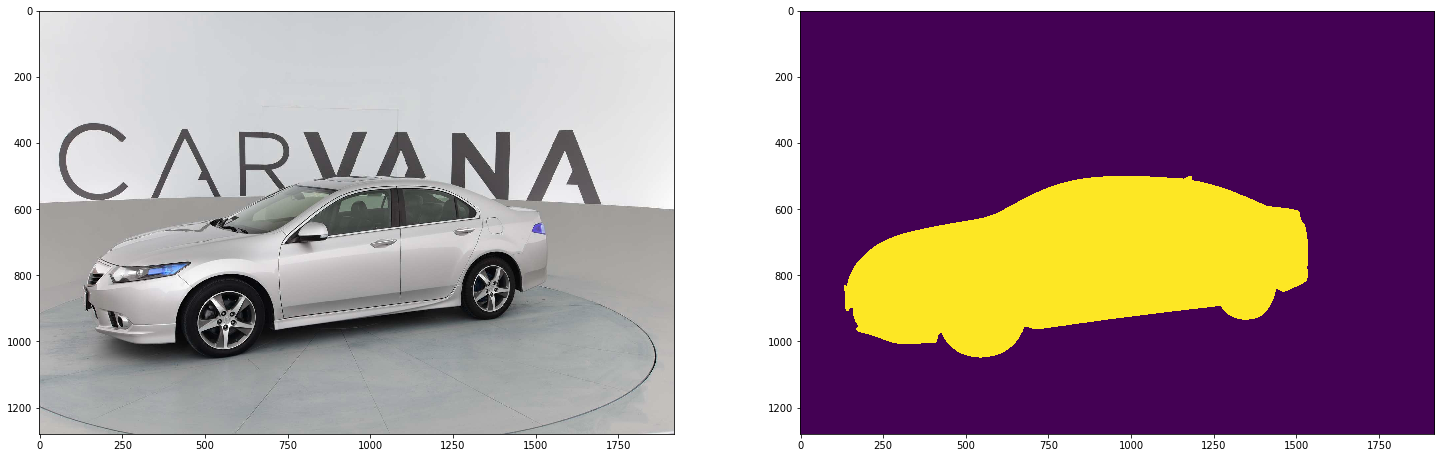

In [10]:
show_img_mask(img, mask)

In [11]:
class CarsDataset(Dataset):
    def __init__(self, csv_file, transform_img=None, transform_mask=None):
        self.csv_file = csv_file
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        img_name, mask_rle = self.csv_file.iloc[idx]

        img = cv2.imread('./train/{}'.format(img_name))
        mask = rle_decode(mask_rle)
        
        
        if self.transform_img is not None:
            img = self.transform_img(img)
        else:
            img = torch.from_numpy(img)
        
        if self.transform_mask is not None:
            mask = self.transform_mask(mask)
        else:
            mask = torch.from_numpy(mask)
            
        mask = mask.view(-1)    
        mask = (mask>0).float()
        return (img.to(device).float(), mask.to(device))
    
    def get(self, idx):
        return self.__getitem__(idx)

In [12]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
invNorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

transform_img = transforms.Compose([transforms.ToPILImage(), transforms.Resize((572, 572)), transforms.ToTensor(), normalize])
transform_mask = transforms.Compose([transforms.ToPILImage(), transforms.Resize((572, 572)), transforms.ToTensor()])

In [13]:
train_dataset = CarsDataset(train_df, transform_img=transform_img, transform_mask=transform_mask)
val_dataset = CarsDataset(val_df, transform_img=transform_img, transform_mask=transform_mask)

In [14]:
i, m = val_dataset.get(10)

In [15]:
i.shape, m.shape

(torch.Size([3, 572, 572]), torch.Size([327184]))

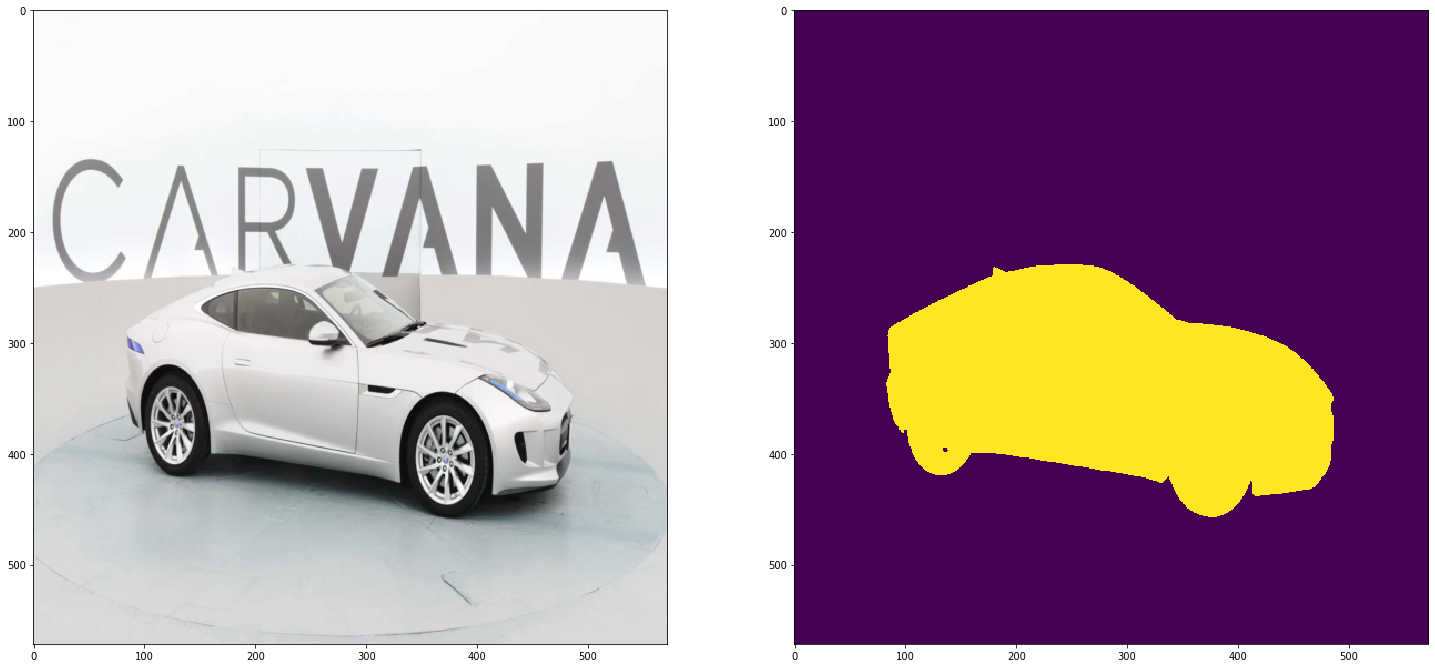

In [16]:
show_img_mask(invNorm(i).permute(1,2,0).cpu(), m.view(1,572,572).permute(1,2,0).cpu() )

In [17]:
del i
del m

In [52]:
batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for t in train_dataloader:
    print(len(t), t[0].shape, t[1].shape)
    break

2 torch.Size([2, 3, 572, 572]) torch.Size([2, 327184])


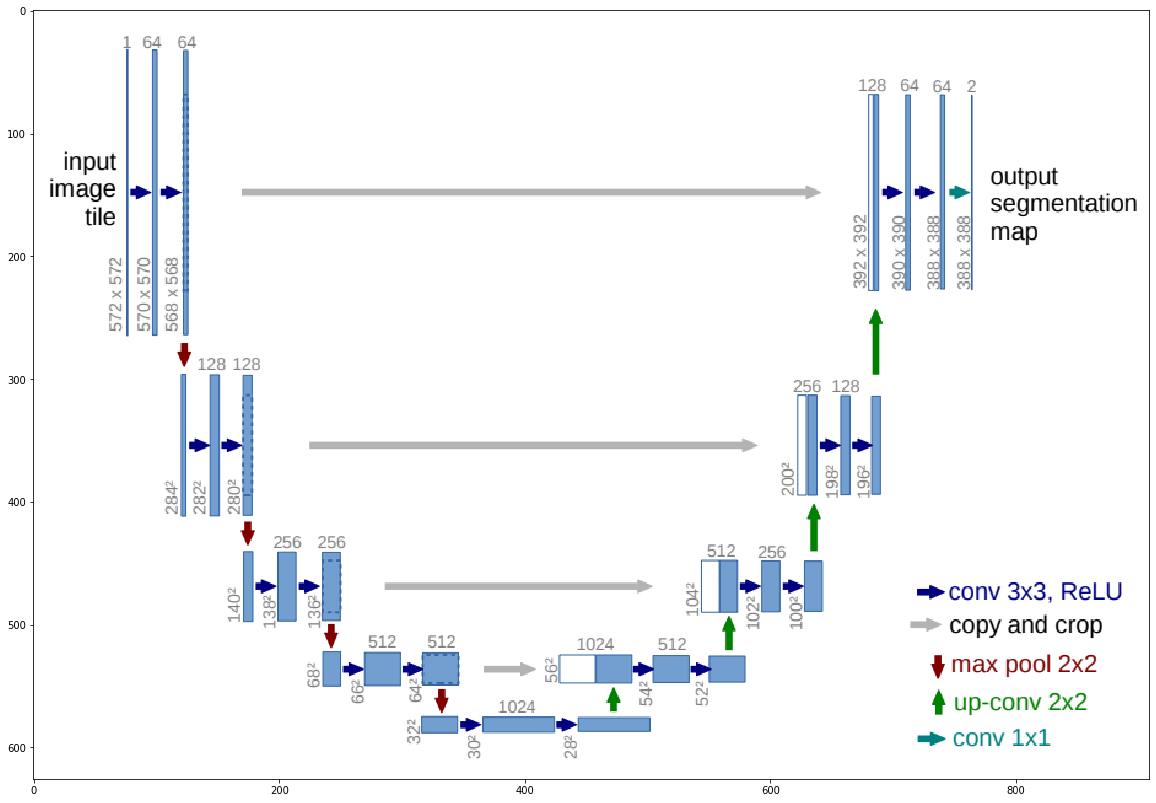

In [22]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [25]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, padding=0, stride=1):
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
        )
        
    def forward(self,x):
        return self.conv_block(x)
        
class UpConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, padding=0, out_padding=0, stride=1):
        super(UpConvBlock, self).__init__()
        
        self.upconv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride, output_padding=out_padding, padding=padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
        )
        
    def forward(self,x):
        return self.upconv_block(x)
    
    
class Unet(nn.Module):
    
    def __init__(self, i):
        super(Unet, self).__init__()
        self.s=64        
        self.l=self.s*np.power(2,i)
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.first_block = nn.Sequential(ConvBlock(3, self.s, kernel_size=3, padding=0, stride=1), 
                                         ConvBlock(self.s, self.s, kernel_size=3, padding=0, stride=1), 
                                        )
        self.encoder = nn.ModuleList([nn.Sequential(
            self.max_pool,
            ConvBlock(self.s*np.power(2,j), 2*self.s*np.power(2,j), kernel_size=3, padding=0, stride=1), 
            ConvBlock(2*self.s*np.power(2,j), 2*self.s*np.power(2,j), kernel_size=3, padding=0, stride=1),
        ) for j in range(i-1)] + [nn.Sequential(
            self.max_pool,
            ConvBlock(self.s*np.power(2,i-1), 2*self.s*np.power(2,i-1), kernel_size=3, padding=0, stride=1), 
            ConvBlock(2*self.s*np.power(2,i-1), 2*self.s*np.power(2,i-1), kernel_size=3, padding=0, stride=1)
        )])
        
        self.decoder = nn.ModuleList([nn.Sequential(
            UpConvBlock(int(self.l/np.power(2,j)), int(self.l/np.power(2,j+1)), kernel_size=2, padding=0, out_padding=0, stride=2),
            nn.Sequential(
            ConvBlock(int(self.l/np.power(2,j)), int(self.l/np.power(2,j+1)), kernel_size=3, padding=0, stride=1),
            ConvBlock(int(self.l/np.power(2,j+1)), int(self.l/np.power(2,j+1)), kernel_size=3, padding=0, stride=1),
        )) for j in range(i)])
        
        self.last_block = nn.Sequential(UpConvBlock(int(self.l/np.power(2,i)), 3, kernel_size=2, padding=0, out_padding=0, stride=2),
                                       nn.Conv2d(3, 1, kernel_size=1, stride=1),
                                       nn.Sigmoid())
        
    def forward(self, x):
        
        h = x.shape[-1]
        encoder_cache = []
        x = self.first_block(x)
        encoder_cache.append(x)
        for i in range(len(self.encoder)):
            x = self.encoder[i](x)
            if i != len(self.encoder)-1:
                encoder_cache.append(x.clone())


        for i in range(len(self.decoder)):
            x = self.decoder[i][0](x)
            e_x = encoder_cache[-(i+1)]
            margin = int((e_x.shape[-1]-x.shape[-1])/2)
            x = torch.cat([x,e_x[:,:,margin:-margin,margin:-margin]],dim=1)
            x = self.decoder[i][1](x)
        
        x = self.last_block(x)
        margin = int((x.shape[-1]-h)/2)
        x = x[:,:,margin:-margin,margin:-margin]
#         print(x.shape)
        x = x.reshape(x.shape[0],-1)
#         del encoder_cache
        return x

In [26]:
model = Unet(2).to(device)

In [28]:
pred = model(t[0].to(device))
pred.shape

torch.Size([2, 327184])

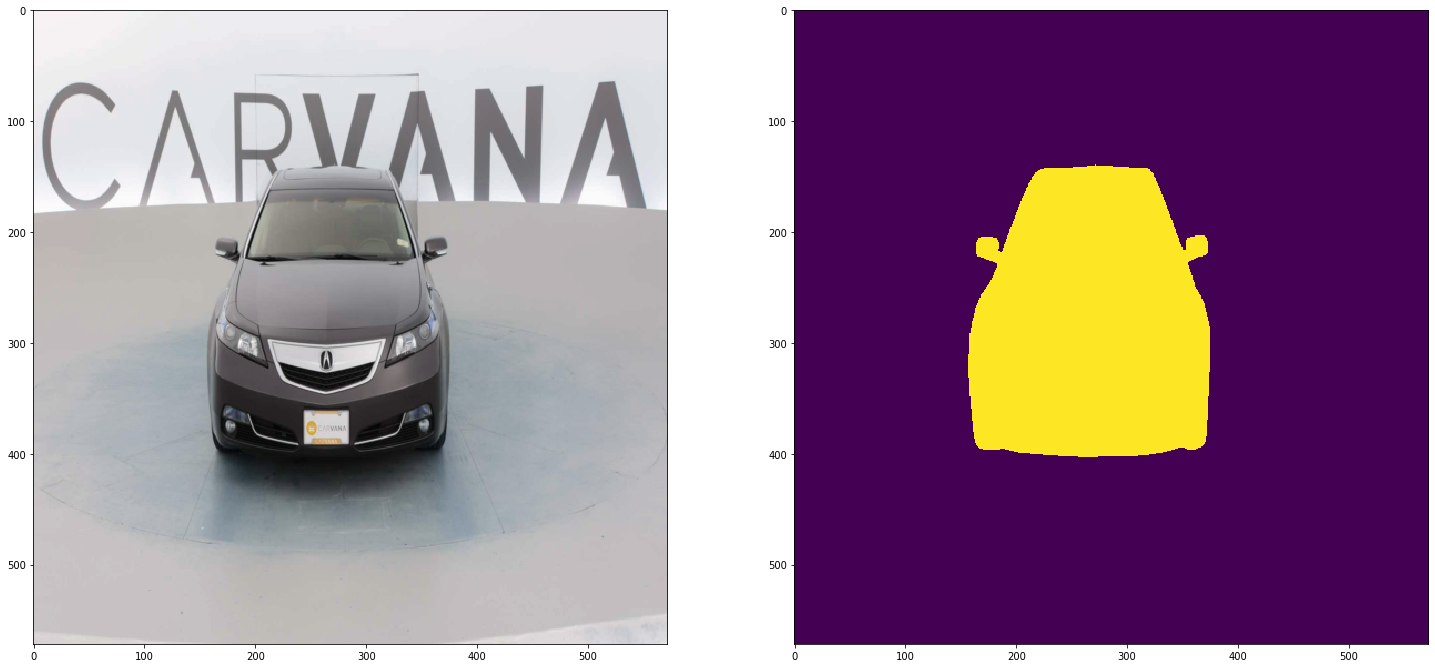

In [31]:
show_img_mask(invNorm(t[0][0]).permute(1,2,0).cpu(), t[1][0].view(1,572,572).permute(1,2,0).cpu()>0)

In [33]:
pred.view(pred.shape[0],1,572,572)[0].shape

torch.Size([1, 572, 572])

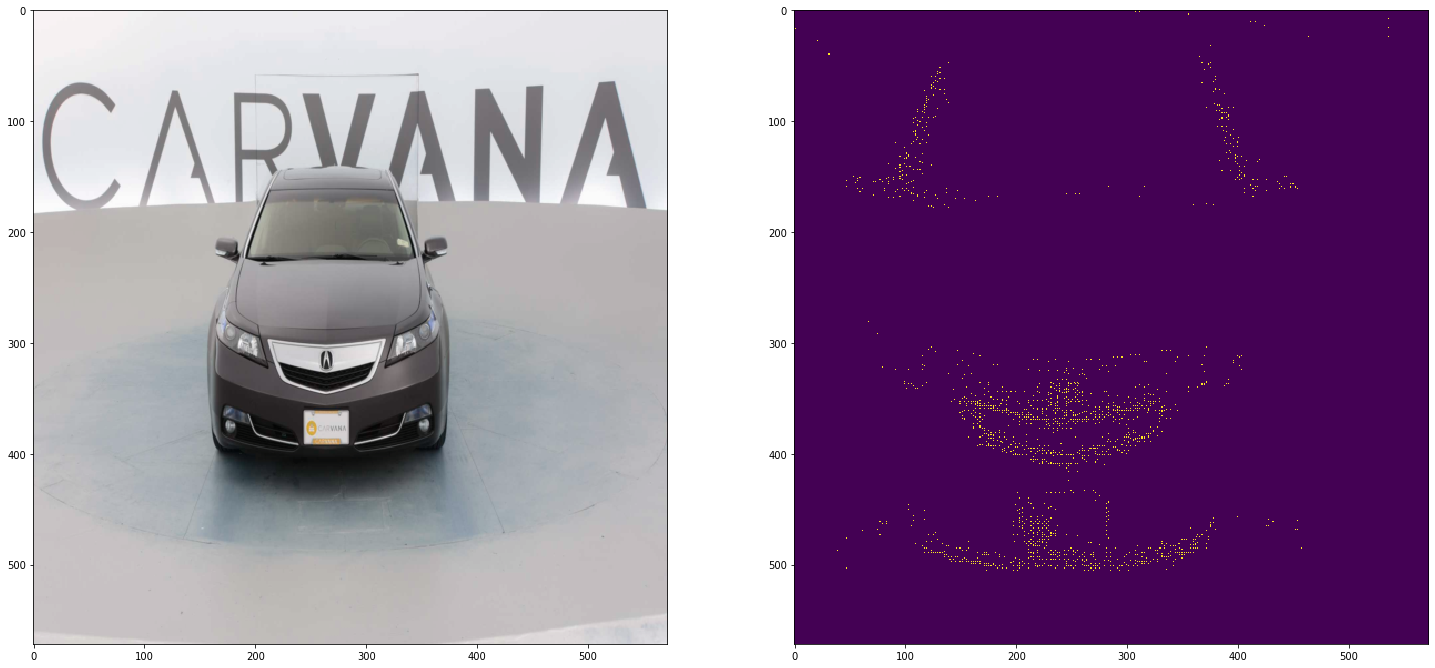

In [34]:
# without train
show_img_mask(invNorm(t[0][0]).permute(1,2,0).cpu(), pred.view(pred.shape[0],1,572,572)[0].permute(1,2,0).cpu()>0.5)

In [35]:
learning_rate = 2e-4
epochs = 100

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [36]:
del t
del pred

In [37]:
import gc
gc.collect()

20896

In [38]:
losses = []

for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_dataloader):
        output = model(images)
        loss = criterion(output, masks)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        gc.collect()
        
        if i % 100 == 0:
            print(epoch, np.array(losses).mean())
            losses = []

0 0.5645685195922852
0 0.5016894349455834
0 0.4689547556638718
0 0.44917856365442277
0 0.4467434665560722
0 0.421217283308506
0 0.4151936250925064
0 0.41365445643663407
0 0.40758096128702165
0 0.39749415546655653
0 0.39044789135456087
0 0.38375036656856537
0 0.37587811678648
0 0.3827840268611908
0 0.36619740664958955
0 0.36566026479005814
0 0.36854416847229005
0 0.36156890690326693
0 0.36455197602510453
0 0.36120284676551817
0 0.3508457726240158
1 0.3523499647776286
1 0.3442210149765015
1 0.34262240201234817
1 0.3467342537641525
1 0.3388921578228474
1 0.33462054297328
1 0.3336607320606709
1 0.3305621275305748
1 0.33037652879953383
1 0.32675852939486505
1 0.3259910628199577
1 0.3270748730003834
1 0.31949538171291353
1 0.31779483005404474
1 0.3143018712103367
1 0.32219103634357454
1 0.32103306919336316
1 0.3119512067735195
1 0.3151801832020283
1 0.31191321820020673
1 0.31626853108406067
2 0.3101926290326648
2 0.3127038210630417
2 0.3062627759575844
2 0.3102931770682335
2 0.30922033324837

KeyboardInterrupt: 

In [42]:
gc.collect()

1620

In [43]:
torch.save(model.state_dict(), './unet1')

In [44]:
model.load_state_dict(torch.load('./unet1'))

<All keys matched successfully>

In [45]:
for t in train_dataloader:
    print(len(t), t[0].shape, t[1].shape)
    break

2 torch.Size([2, 3, 572, 572]) torch.Size([2, 327184])


In [46]:
out = model(t[0].to(device))

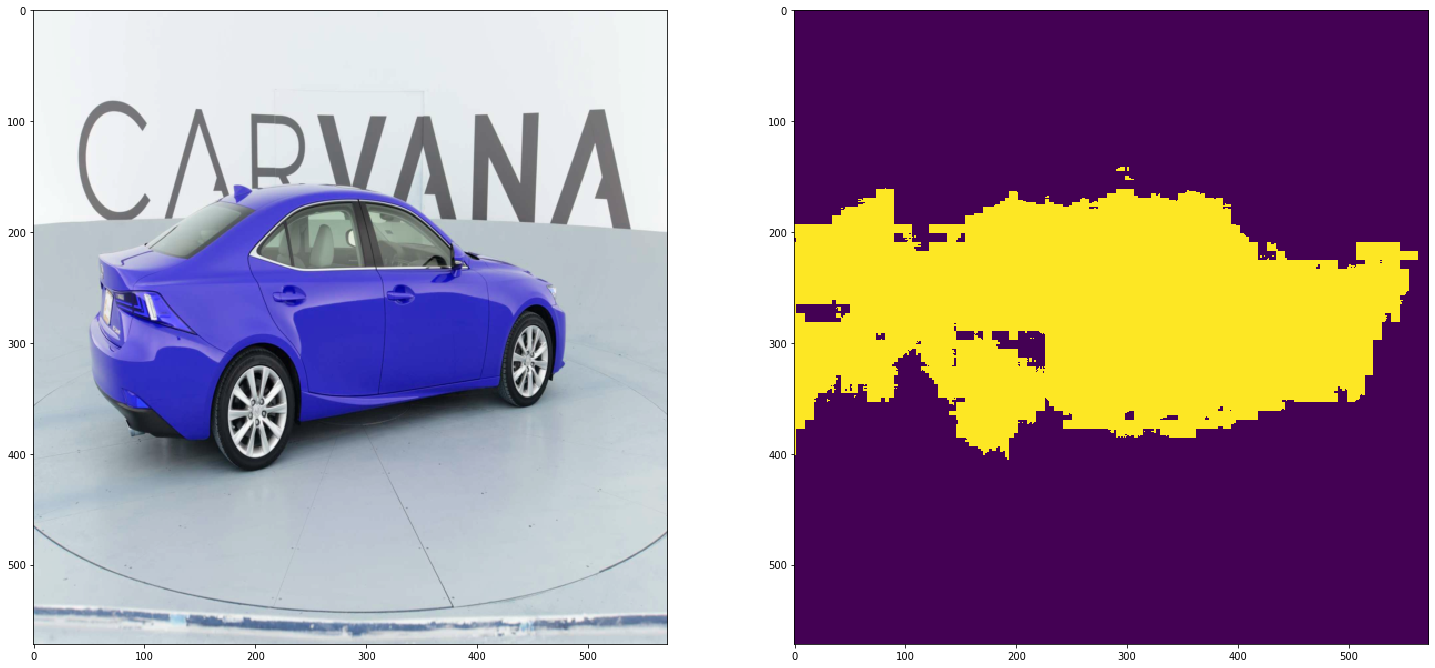

In [47]:
show_img_mask(invNorm(t[0][0]).permute(1,2,0).cpu(), out.view(out.shape[0],1,572,572)[0].permute(1,2,0).cpu()>0.5)

In [51]:
del t

In [53]:
for t in val_dataloader:
    print(len(t), t[0].shape, t[1].shape)
    break

2 torch.Size([2, 3, 572, 572]) torch.Size([2, 327184])


In [54]:
out = model(t[0].to(device))

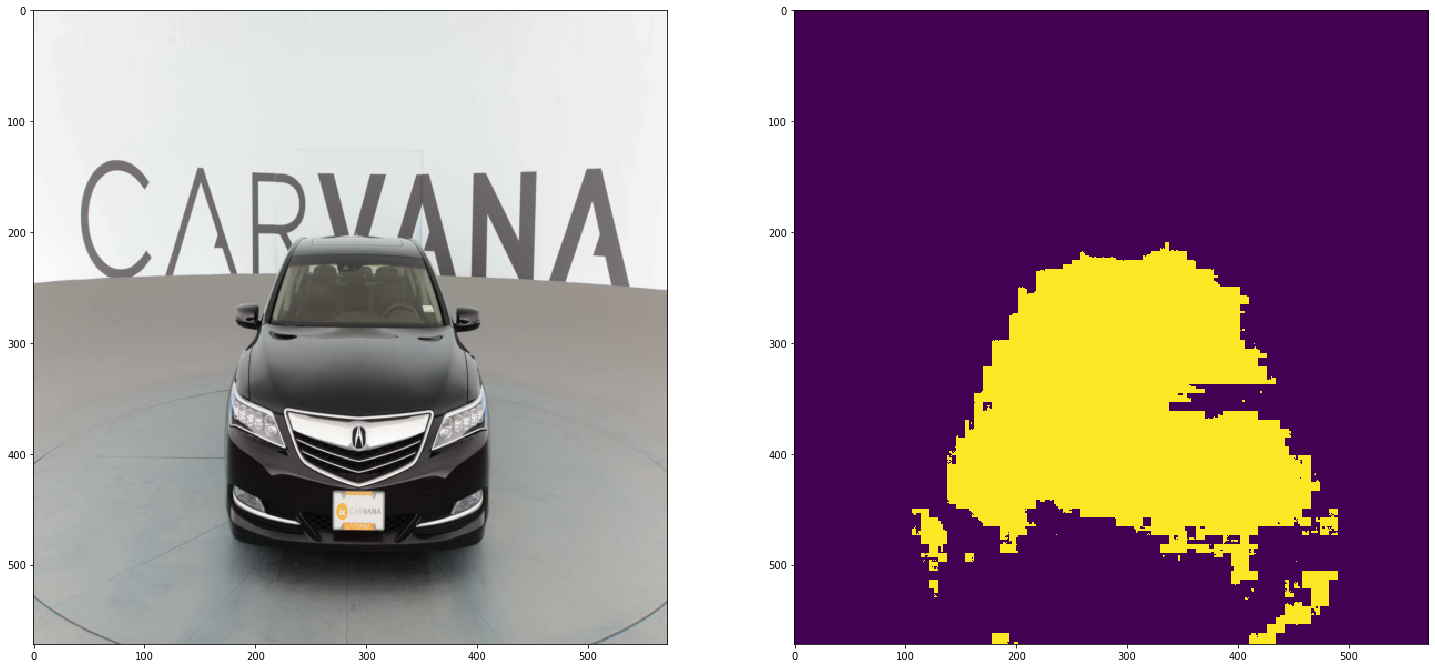

In [55]:
show_img_mask(invNorm(t[0][0]).permute(1,2,0).cpu(), out.view(out.shape[0],1,572,572)[0].permute(1,2,0).cpu()>0.5)